# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
!aws s3 ls sagemaker-us-east-1-709614815312 --recursive > list.txt

In [11]:
!pip install smdebug
!pip install torch torchvision

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [5]:
import sagemaker
import boto3
import os

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [6]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dog-image-data"
role = sagemaker.get_execution_role()

In [ ]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)

## TRAIN WITH PRETRAINED MODEL

In [10]:
from sagemaker.pytorch import PyTorch
import os

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
)

estimator.fit({'train': 's3://sagemaker-us-east-1-709614815312/dog-image-data'})

2022-01-02 04:33:00 Starting - Starting the training job...
2022-01-02 04:33:24 Starting - Launching requested ML instancesProfilerReport-1641097979: InProgress
......
2022-01-02 04:34:24 Starting - Preparing the instances for training......
2022-01-02 04:35:26 Downloading - Downloading input data.........
2022-01-02 04:36:54 Training - Downloading the training image..........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-02 04:38:37,101 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-02 04:38:37,103 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-02 04:38:37,111 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-02 04:38:40,132 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-02 04:38:40,610 sagemaker-training-toolkit INFO     No GPUs detec

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [18]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.1, 0.11),
    "batch-size": CategoricalParameter([16, 32]),
    "epochs": IntegerParameter(1, 2)
}

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Test set: Average accuracy: ([0-9\\.]+)"}]

In [19]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [20]:
# TODO: Fit your HP Tuner
tuner.fit({"train": 's3://sagemaker-us-east-1-709614815312/dog-image-data'}) # TODO: Remember to include your data channels

....................................................................................................................................................................................!


In [21]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-02 05:56:52 Starting - Preparing the instances for training
2022-01-02 05:56:52 Downloading - Downloading input data
2022-01-02 05:56:52 Training - Training image download completed. Training in progress.
2022-01-02 05:56:52 Uploading - Uploading generated training model
2022-01-02 05:56:52 Completed - Training job completed


{'_tuning_objective_metric': '"average test accuracy"',
 'batch-size': '"32"',
 'epochs': '1',
 'lr': '0.1051250412476169',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-02-05-49-37-618"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-709614815312/pytorch-training-2022-01-02-05-49-37-618/source/sourcedir.tar.gz"'}

In [22]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}
hyperparameters

{'batch-size': 32, 'lr': '0.1051250412476169', 'epochs': '1'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [8]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    ProfilerRule,
    rule_configs,
    ProfilerConfig, 
    FrameworkProfile,
    
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "10",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=1000, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [32]:
hyperparameters = {'batch-size': 32, 'lr': '0.1051250412476169', 'epochs': '2'}

In [ ]:
from sagemaker.pytorch import PyTorch
import os

estimator = PyTorch(
    entry_point='train_model.py',
    base_job_name='dogImageEstimator',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.8',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

estimator.fit({"train": 's3://sagemaker-us-east-1-709614815312/dog-image-data'}, wait = True)


2022-01-04 06:15:12 Starting - Starting the training job...
2022-01-04 06:15:42 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-01-04 06:16:42 Starting - Preparing the instances for training.........
2022-01-04 06:18:03 Downloading - Downloading input data.........
2022-01-04 06:19:44 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-04 06:19:49,123 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-04 06:19:49,125 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-04 06:19:49,134 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-04 06:19:49,142 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-04

In [34]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

trial.tensor_names()

[2022-01-04 06:32:20.155 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:20 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-709614815312/dogImageEstimator-2022-01-04-06-15-12-256/debug-output


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight']

In [36]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

42

In [27]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


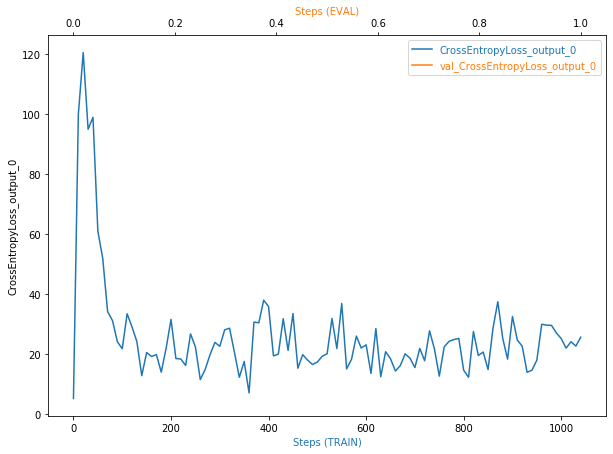

In [29]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [43]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [44]:
!aws s3 ls {rule_output_path} --recursive

2022-01-02 07:07:49     365238 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-02 07:07:48     212307 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-02 07:07:44        191 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-02 07:07:44        199 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-02 07:07:44       2110 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-02 07:07:44        127 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-02 07:07:44        198 dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/prof

In [45]:
!aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-709614815312/dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-709614815312/dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-709614815312/dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-709614815312/dogImageEstimator-2022-01-02-07-01-57-942/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-

In [47]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [4]:
from sagemaker.predictor import Predictor

identity_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=identity_serializer,
            deserializer=json_deserializer,
        )


In [46]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data="s3://sagemaker-us-east-1-709614815312/model.tar.gz", role=role, entry_point='inference.py', py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [47]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [58]:
from PIL import Image
import io
buf = io.BytesIO()
Image.open("dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg").save(buf, format="JPEG")

response = predictor.predict(buf.getvalue())

In [59]:
import numpy as np
np.argmax(response, 1)

array([22])

In [45]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()